## Введение

### Цели
- познакомиться с модулем `re` в Python
- узнать основные конструкции регулярных выражений
- получить практический навык решения задачи с использованием регулярных выражений

### Задачи

- изучить структуру VIN-кода, какие информационные компоненты он содержит (регион, производитель, характеристики автомобиля и т. д.).
- составить регулярные выражения для поиска и извлечения конкретных частей VIN-кода, таких как производитель, модель и год выпуска.
- решить задачи на основе датасета с VIN-кодами, например поиск определенных моделей автомобилей
- найти ошибки в VIN-кодах с помощью регулярных выражений



### Форматы VIN

The number consists of both alpha and numeric characters. VIN characters may be capital letters A through Z and numbers 1 through 0; however, the letters I, O and Q are never used in order to avoid mistakes of misreading. No signs or spaces are allowed in the VIN.No two VIN's are the same.



In [134]:
import re
import pandas as pd

import numpy as np

import joblib


import matplotlib.pyplot as plt
import seaborn as sns

!pip install catboost
from catboost import CatBoostRegressor
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

VIN код состоит из 17 знаков:

* 1-3 производитель
* 4 ремни безопасности, либо тормоза и грузоподьемность
* 5-7 модель
* 8 двигатель
* 9 контрольный знак
* 10 год
* 11 завод-изготовитель
* 12-17 серийный номер

# Загрузка и обработка файла

In [135]:
# загружаем файл
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [136]:
with open('/content/gdrive/MyDrive/vin_ford_train.txt', 'r') as f:
  content = f.read()

In [137]:
content[:100]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421'

In [138]:
# определим допустимые символы
CHARS = [chr(x) for x in range(ord('A'), ord ('Z')+1) if chr(x) not in ('I', 'O', 'Q')]# список содержит все буквы латинского алфавита от 'A' до 'Z', за исключением букв 'I', 'O' и 'Q'.
NUMS = ['\\d'] # любая цифра
ALLOWED = ''.join(CHARS+NUMS)


In [139]:
#строим регулярное выражение

prod_re = f'(?P<prod>[{ALLOWED}]{{3}})'
seat_belts_re = f'(?P<seat_belts>[{ALLOWED}])'
model_re = f'(?P<model>[{ALLOWED}]{{3}})'
engine_re = f'(?P<engine>[{ALLOWED}])'
check_re = f'(?P<check>[{ALLOWED}])'
year_re = f'(?P<year>[{ALLOWED}])'
plant_re = f'(?P<plant>[{ALLOWED}])'
vis_re = f'(?P<vis>[{ALLOWED}]{{3}}\\d{{3}})'

vin = f'{prod_re}{seat_belts_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{vis_re}'
price_re = r'(?P<price>\d+)'



In [140]:
data_re = re.compile(f'\\[({vin}):({price_re})\\]')

data_re

re.compile(r'\[((?P<prod>[ABCDEFGHJKLMNPRSTUVWXYZ\d]{3})(?P<seat_belts>[ABCDEFGHJKLMNPRSTUVWXYZ\d])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ\d]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ\d])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ\d])(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ\d])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ\d])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ\d]{3}\d{3})):((?P<price>\d+))\]',
re.UNICODE)

In [141]:
values = []

for i in data_re.finditer(content):
  values.append(i.groupdict())

values[:4]

[{'prod': '2FM',
  'seat_belts': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'},
 {'prod': '3FA',
  'seat_belts': '6',
  'model': 'P0H',
  'engine': '7',
  'check': '5',
  'year': 'E',
  'plant': 'R',
  'vis': '208976',
  'price': '14500'},
 {'prod': '3FA',
  'seat_belts': 'H',
  'model': 'P08',
  'engine': 'Z',
  'check': '1',
  'year': '7',
  'plant': 'R',
  'vis': '268380',
  'price': '1300'},
 {'prod': '1FM',
  'seat_belts': 'C',
  'model': 'U0G',
  'engine': 'X',
  'check': '3',
  'year': 'D',
  'plant': 'U',
  'vis': 'C59421',
  'price': '15200'}]

In [142]:
# ищем невалидные объекты

valid_vin = r'(\w{14}\d{3})'
valid_price = r'(\d+)'

invalid_vin = r'(?!\w{14}\d{3})(\w+)'
invalid_price = r'(?!\d+)(\w+)'

invalid_variance = [
    f'\\[{invalid_vin}:{invalid_price}]',
    f'\\[{invalid_vin}:{valid_price}]',
    f'\\[{valid_vin}:{invalid_price}]'
]


invalid_pattern = re.compile('(?P<invalid_data>' + '|'.join(invalid_variance) + ')')


invalid_values = []

for i in invalid_pattern.finditer(content):
  invalid_values.append(i.groupdict())

invalid_values


[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

In [143]:
# создадим датасет
df = pd.DataFrame(values)
df.head()




,prod,seat_belts,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prod        71884 non-null  object
 1   seat_belts  71884 non-null  object
 2   model       71884 non-null  object
 3   engine      71884 non-null  object
 4   check       71884 non-null  object
 5   year        71884 non-null  object
 6   plant       71884 non-null  object
 7   vis         71884 non-null  object
 8   price       71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


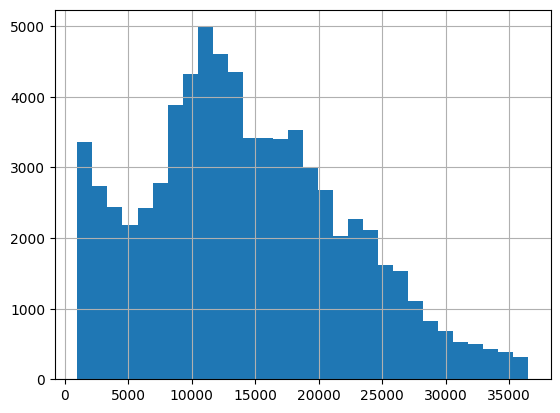

In [145]:
df['price'] = df['price'].astype('int')

df['price'].hist(bins=30);

In [146]:
df['prod'].unique() # все вины американские

array(['2FM', '3FA', '1FM', '1FA', '1FT', '1ZV', '1FD', '2FA', '2FT',
       '1FB', '4F2', '4F4', '3FT', '4N2'], dtype=object)

In [147]:
replacement_prod = {
    '1F1': 'США',
    '1F6': 'США',
    '1F7': 'США',
    '1F8': 'США',
    '1FA': 'США',
    '1FB': 'США',
    '1FC': 'США',
    '1FD': 'США',
    '1FT': 'США',
    '1FM': 'США',
    '1ZV': 'США',
    '1ZW': 'США',
    '2FA': 'Канада',
    '2FD': 'Канада',
    '2FM': 'Канада',
    '2FT': 'Канада',
    '3FA': 'Мексика',
    '3FB': 'Мексика',
    '3FD': 'Мексика',
    '3FE': 'Мексика',
    '3FN': 'Мексика',
    '3FR': 'Мексика',
    '3FT': 'Мексика',
    '3M9': 'Мексика',
    '4N2': 'США',
    '4F2': 'США',
    '4F4': 'США'
}

df['prod'] = df['prod'].map(replacement_prod)

df

,prod,seat_belts,model,engine,check,year,plant,vis,price
0,Канада,D,K3J,C,4,B,B,A41556,12500
1,Мексика,6,P0H,7,5,E,R,208976,14500
2,Мексика,H,P08,Z,1,7,R,268380,1300
3,США,C,U0G,X,3,D,U,C59421,15200
4,США,H,P2E,8,9,D,G,119368,11600
...,...,...,...,...,...,...,...,...,...
71879,США,D,X17,W,1,V,N,B73890,1000
71880,США,D,P3F,2,3,D,L,169365,12200
71881,Мексика,6,P0H,D,2,E,R,142859,16300
71882,США,H,P34,N,7,6,W,128169,1500


In [148]:
df['seat_belts'].unique()

array(['D', '6', 'H', 'C', '5', 'F', 'Z', 'G', 'B', 'N', 'J', 'P', 'M',
       'R', 'E', 'S', 'K', 'Y', 'X', '8', 'W', '7', 'V', 'L', '4', 'A'],
      dtype=object)

In [149]:
#не все описания данного ключа есть, не знаю где смотреть, заменила на -1

def process_seat_belts(value):
    # Создаем словарь для соответствия значений
    seat_belts_dict = {
        'B': ('обычные', 0, 0),  # Без подушек безопасности
        'P': ('обычные', 0, 0),  # Без подушек безопасности
        'C': ('автоматические', 1, 0),  # С подушкой безопасности для водителя
        'A': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'L': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'F': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'K': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'H': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'D': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        '6': ('автоматические', 1, 1),  # С подушками безопасности для водителя и пассажира
        'G': ('автоматические', 1, 1)   # С подушками безопасности для водителя и пассажира
    }
    return seat_belts_dict.get(value, (None, None, None))

df[['seat_belts_type', 'driver_airbag', 'passenger_airbag']] = df['seat_belts'].apply(lambda x: pd.Series(process_seat_belts(x)))

df = df.fillna(-1)

df


,prod,seat_belts,model,engine,check,year,plant,vis,price,seat_belts_type,driver_airbag,passenger_airbag
0,Канада,D,K3J,C,4,B,B,A41556,12500,автоматические,1.0,1.0
1,Мексика,6,P0H,7,5,E,R,208976,14500,автоматические,1.0,1.0
2,Мексика,H,P08,Z,1,7,R,268380,1300,автоматические,1.0,1.0
3,США,C,U0G,X,3,D,U,C59421,15200,автоматические,1.0,0.0
4,США,H,P2E,8,9,D,G,119368,11600,автоматические,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71879,США,D,X17,W,1,V,N,B73890,1000,автоматические,1.0,1.0
71880,США,D,P3F,2,3,D,L,169365,12200,автоматические,1.0,1.0
71881,Мексика,6,P0H,D,2,E,R,142859,16300,автоматические,1.0,1.0
71882,США,H,P34,N,7,6,W,128169,1500,автоматические,1.0,1.0


In [150]:
df['first_letter'] = df['model'].str.slice(0, 1)

# Создание карта категорий
category_mapping = {
    'C': 'шасси',
    'E': 'фургоны',
    'F': 'шасси',
    'S': 'фургоны_удл'
}

# Функция для преобразования первой буквы в категорию
def categorize_model(first_letter):
    if first_letter in category_mapping:
        return category_mapping[first_letter]
    else:
        return 'пассажирские'

# Создание нового столбца 'category' на основе первой буквы
df['category'] = df['first_letter'].apply(categorize_model)

In [151]:
df['category'].value_counts()

category
пассажирские    66890
фургоны          2572
шасси            1592
фургоны_удл       830
Name: count, dtype: int64

Была сделана попытка

In [152]:
df_year=pd.read_excel('/content/gdrive/MyDrive/year.xls', index_col=0).reset_index()
df_year

,Code,Years
0,A,"1980, 2010"
1,B,"1981, 2011"
2,C,"1982, 2012"
3,D,"1983, 2013"
4,E,"1984, 2014"
5,F,"1985, 2015"
6,G,"1986, 2016"
7,H,"1987, 2017"
8,J,"1988, 2018"
9,K,"1989, 2019"


In [153]:
df_model=pd.read_excel('/content/gdrive/MyDrive/model.xls', index_col=0).reset_index()
df_model = df_model.dropna().reset_index()
df_model

,index,VIN,Unnamed: 1
0,1,A11,Ford Aerostar regular length passenger van ('8...
1,2,A14,Ford Aerostar regular length cargo van ('86-'97)
2,3,A15,Ford Aerostar regular length cargo van w/side ...
3,4,A21,Ford Aerostar regular length passenger van 4WD...
4,5,A24,Ford Aerostar regular length cargo van 4WD ('9...
...,...,...,...
1668,3429,Z96,"Ford CL9000, 64 in. Non-Sleeper Cab ('81-'91)"
1669,3430,Z97,"Ford CL9000, 76 in. Sleeper Cab ('81-'82)"
1670,3431,Z98 \t,"Ford CL9000, 88 in. Sleeper Cab ('81-'91)"
1671,3438,Z92,"Ford L9511 (Louisville 9500 Series, 111 in. BB..."


In [154]:
df_engine=pd.read_excel('/content/gdrive/MyDrive/engine.xls', index_col=0).reset_index()
df_engine = df_engine.fillna('')

df_engine

,Fuel,Power (hp),Power (kW),VIN code,Notes/Applications
0,Gasoline,123,91,E,"Ford Fiesta ('14-'17),\nFord Focus ('15-'18)"
1,Gasoline,86-88,63-65,A,"Ford Mustang, Mercury Capri, Ford Fairmont, Me..."
2,Propane,86,63,6,"Ford Granada, Mercury Cougar ('82)"
3,Gasoline,88-90,65-66,A,"Ford Mustang, Mercury Capri ('83-'86), Ford Fa..."
4,Propane,88,65,6,"Ford LTD, Mercury Marquis ('83-'84)"
...,...,...,...,...,...
302,Gasoline,305-310,227-231,S,
303,Bi-Fuel NGV/LPG,295-305,220-227,B,
304,Gasoline-GFP,305-310,227-231,Z,
305,Gasoline-GFP,362,,"D, P",Ford F-650/F-750 ('12-'15)


In [155]:
# Паттерн для поиска первых двух слов в описании
name_pattern = r'^(\b\w+\b\s\b\w+\b)'


# Извлечение данных и создание новых столбцов
df_model['name'] = df_model['Unnamed: 1'].apply(lambda x: re.search(name_pattern, x).group(1).strip() if re.search(name_pattern, x) else None)


# Исправленный паттерн для поиска года в скобках
years_pattern = r'\((\'(\d{2})-?\'(\d{2})?)\)'

# Функция для извлечения годов
def extract_years(text):
    matches = re.findall(years_pattern, text)
    if matches:
        first_match = matches[0] # Первое совпадение
        last_match = matches[-1] # Последнее совпадение
        start_year = first_match[1] # Первый год из последнего совпадения
        end_year = last_match[2] if last_match[2] else None # Второй год, если он есть

        # Обработка годов
        start_year = int(start_year)
        if start_year <= 50:
            start_year += 2000
        else:
            start_year += 1900

        # Если второй год не указан, устанавливаем его равным 2023
        if not end_year:
            end_year = 2023
        else:
            end_year = int(end_year)
            if end_year <= 50:
                end_year += 2000
            else:
                end_year += 1900

        return start_year, end_year

    return None, None

# Предположим, что df_model - это ваш DataFrame
# Создаем новые столбцы start_year и end_year
df_model['start_year'], df_model['end_year'] = zip(*df_model['Unnamed: 1'].apply(lambda x: extract_years(x)))



df_model = df_model.fillna(0)

df_model.head(20)
df_model.loc[df_model['VIN']=='K3J']

,index,VIN,Unnamed: 1,name,start_year,end_year
354,588,K3J,"Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20...",Ford Edge,2010.0,2021.0


In [156]:
df_model

,index,VIN,Unnamed: 1,name,start_year,end_year
0,1,A11,Ford Aerostar regular length passenger van ('8...,Ford Aerostar,1986.0,1997.0
1,2,A14,Ford Aerostar regular length cargo van ('86-'97),Ford Aerostar,1986.0,1997.0
2,3,A15,Ford Aerostar regular length cargo van w/side ...,Ford Aerostar,1986.0,1994.0
3,4,A21,Ford Aerostar regular length passenger van 4WD...,Ford Aerostar,1990.0,1994.0
4,5,A24,Ford Aerostar regular length cargo van 4WD ('9...,Ford Aerostar,1990.0,1994.0
...,...,...,...,...,...,...
1668,3429,Z96,"Ford CL9000, 64 in. Non-Sleeper Cab ('81-'91)",Ford CL9000,1981.0,1991.0
1669,3430,Z97,"Ford CL9000, 76 in. Sleeper Cab ('81-'82)",Ford CL9000,1981.0,1982.0
1670,3431,Z98 \t,"Ford CL9000, 88 in. Sleeper Cab ('81-'91)",Ford CL9000,1981.0,1991.0
1671,3438,Z92,"Ford L9511 (Louisville 9500 Series, 111 in. BB...",Ford L9511,0.0,0.0


In [157]:
df['year'] = df['year'].astype(str)
df_year['Code'] = df_year['Code'].astype(str)

merged_df = pd.merge(df, df_year, left_on='year', right_on='Code', how='left')
merged_df = merged_df.drop(['Code', 'year', 'first_letter', 'vis'], axis=1, errors = 'ignore')

In [158]:
merged_df

,prod,seat_belts,model,engine,check,plant,price,seat_belts_type,driver_airbag,passenger_airbag,category,Years
0,Канада,D,K3J,C,4,B,12500,автоматические,1.0,1.0,пассажирские,"1981, 2011"
1,Мексика,6,P0H,7,5,R,14500,автоматические,1.0,1.0,пассажирские,"1984, 2014"
2,Мексика,H,P08,Z,1,R,1300,автоматические,1.0,1.0,пассажирские,"2007, 2037"
3,США,C,U0G,X,3,U,15200,автоматические,1.0,0.0,пассажирские,"1983, 2013"
4,США,H,P2E,8,9,G,11600,автоматические,1.0,1.0,пассажирские,"1983, 2013"
...,...,...,...,...,...,...,...,...,...,...,...,...
71879,США,D,X17,W,1,N,1000,автоматические,1.0,1.0,пассажирские,"1997, 2027"
71880,США,D,P3F,2,3,L,12200,автоматические,1.0,1.0,пассажирские,"1983, 2013"
71881,Мексика,6,P0H,D,2,R,16300,автоматические,1.0,1.0,пассажирские,"1984, 2014"
71882,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036"


In [159]:
merged_df = pd.merge(merged_df, df_model, left_on='model', right_on='VIN', how='left')
merged_df = merged_df.drop(['index', 'VIN', 'years'], axis=1, errors = 'ignore')

In [160]:
merged_df

,prod,seat_belts,model,engine,check,plant,price,seat_belts_type,driver_airbag,passenger_airbag,category,Years,Unnamed: 1,name,start_year,end_year
0,Канада,D,K3J,C,4,B,12500,автоматические,1.0,1.0,пассажирские,"1981, 2011","Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20...",Ford Edge,2010.0,2021.0
1,Мексика,6,P0H,7,5,R,14500,автоматические,1.0,1.0,пассажирские,"1984, 2014","Ford Fusion; SE, FWD ('10-'12)",Ford Fusion,2010.0,2012.0
2,Мексика,6,P0H,7,5,R,14500,автоматические,1.0,1.0,пассажирские,"1984, 2014","Ford Fusion; SE, FWD ('13-'20)",Ford Fusion,2013.0,2020.0
3,Мексика,H,P08,Z,1,R,1300,автоматические,1.0,1.0,пассажирские,"2007, 2037","Ford Fusion; SEL, FWD ('06-'09)",Ford Fusion,2006.0,2009.0
4,США,C,U0G,X,3,U,15200,автоматические,1.0,0.0,пассажирские,"1983, 2013",Ford Escape SE 4x2 ('13-'19),Ford Escape,2013.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122505,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Tempo, 2-door sedan; AWD ('87)",Ford Tempo,0.0,0.0
122506,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Focus, Sedan; SE ('00-'04), ZX4 S/SE/SES ...",Ford Focus,2000.0,2007.0
122507,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Focus, 4-door sedan; S ('08-'09)",Ford Focus,2008.0,2009.0
122508,США,C,U9D,7,8,K,7200,автоматические,1.0,0.0,пассажирские,"1980, 2010",Ford Escape XLT 4x4 ('10-'12),Ford Escape,2010.0,2012.0


In [161]:
# Функция для выбора нужного значения из столбца 'Years'

def select_year(row):
    years = [int(year) for year in row['Years '].split(', ')]
    if years[1] > 2023:
        return years[0]
    else:
        return years[1] if row['start_year'] <= years[1] <= row['end_year'] else years[0]

merged_df['Selected Year'] = merged_df.apply(select_year, axis=1)

merged_df

,prod,seat_belts,model,engine,check,plant,price,seat_belts_type,driver_airbag,passenger_airbag,category,Years,Unnamed: 1,name,start_year,end_year,Selected Year
0,Канада,D,K3J,C,4,B,12500,автоматические,1.0,1.0,пассажирские,"1981, 2011","Ford Edge; SEL FWD ('10-'21), ST-Line FWD ('20...",Ford Edge,2010.0,2021.0,2011
1,Мексика,6,P0H,7,5,R,14500,автоматические,1.0,1.0,пассажирские,"1984, 2014","Ford Fusion; SE, FWD ('10-'12)",Ford Fusion,2010.0,2012.0,1984
2,Мексика,6,P0H,7,5,R,14500,автоматические,1.0,1.0,пассажирские,"1984, 2014","Ford Fusion; SE, FWD ('13-'20)",Ford Fusion,2013.0,2020.0,2014
3,Мексика,H,P08,Z,1,R,1300,автоматические,1.0,1.0,пассажирские,"2007, 2037","Ford Fusion; SEL, FWD ('06-'09)",Ford Fusion,2006.0,2009.0,2007
4,США,C,U0G,X,3,U,15200,автоматические,1.0,0.0,пассажирские,"1983, 2013",Ford Escape SE 4x2 ('13-'19),Ford Escape,2013.0,2019.0,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122505,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Tempo, 2-door sedan; AWD ('87)",Ford Tempo,0.0,0.0,2006
122506,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Focus, Sedan; SE ('00-'04), ZX4 S/SE/SES ...",Ford Focus,2000.0,2007.0,2006
122507,США,H,P34,N,7,W,1500,автоматические,1.0,1.0,пассажирские,"2006, 2036","Ford Focus, 4-door sedan; S ('08-'09)",Ford Focus,2008.0,2009.0,2006
122508,США,C,U9D,7,8,K,7200,автоматические,1.0,0.0,пассажирские,"1980, 2010",Ford Escape XLT 4x4 ('10-'12),Ford Escape,2010.0,2012.0,2010


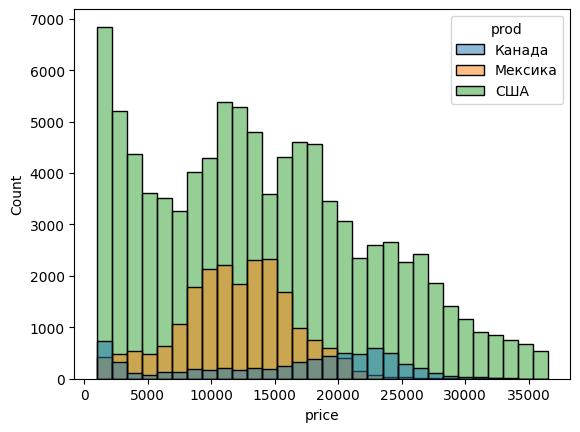

In [162]:
sns.histplot(data=merged_df, x="price", hue="prod", bins=30);

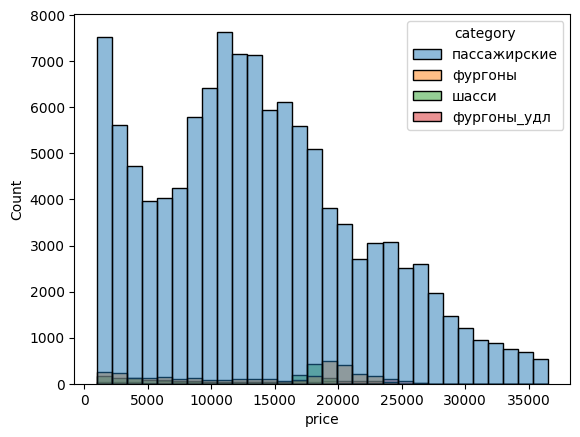

In [163]:
sns.histplot(data=merged_df, x="price", hue="category", bins=30);

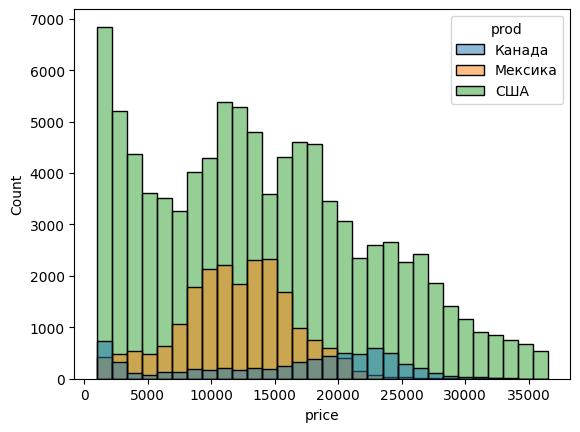

In [164]:
sns.histplot(data=merged_df, x="price", hue="prod", bins=30);

In [165]:
merged_df = merged_df.drop(['Years ', 'Unnamed: 1', 'start_year', 'end_year', 'check', 'name'], axis=1, errors = 'ignore')

In [166]:
merged_df = merged_df.fillna(-1)
merged_df['driver_airbag']=merged_df['driver_airbag'].astype(int)
merged_df['passenger_airbag']=merged_df['passenger_airbag'].astype(int)
merged_df

,prod,seat_belts,model,engine,plant,price,seat_belts_type,driver_airbag,passenger_airbag,category,Selected Year
0,Канада,D,K3J,C,B,12500,автоматические,1,1,пассажирские,2011
1,Мексика,6,P0H,7,R,14500,автоматические,1,1,пассажирские,1984
2,Мексика,6,P0H,7,R,14500,автоматические,1,1,пассажирские,2014
3,Мексика,H,P08,Z,R,1300,автоматические,1,1,пассажирские,2007
4,США,C,U0G,X,U,15200,автоматические,1,0,пассажирские,2013
...,...,...,...,...,...,...,...,...,...,...,...
122505,США,H,P34,N,W,1500,автоматические,1,1,пассажирские,2006
122506,США,H,P34,N,W,1500,автоматические,1,1,пассажирские,2006
122507,США,H,P34,N,W,1500,автоматические,1,1,пассажирские,2006
122508,США,C,U9D,7,K,7200,автоматические,1,0,пассажирские,2010


In [167]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122510 entries, 0 to 122509
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   prod              122510 non-null  object
 1   seat_belts        122510 non-null  object
 2   model             122510 non-null  object
 3   engine            122510 non-null  object
 4   plant             122510 non-null  object
 5   price             122510 non-null  int64 
 6   seat_belts_type   122510 non-null  object
 7   driver_airbag     122510 non-null  int64 
 8   passenger_airbag  122510 non-null  int64 
 9   category          122510 non-null  object
 10  Selected Year     122510 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 10.3+ MB


In [168]:
merged_df.columns

Index(['prod', 'seat_belts', 'model', 'engine', 'plant', 'price',
       'seat_belts_type', 'driver_airbag', 'passenger_airbag', 'category',
       'Selected Year'],
      dtype='object')

Дамми модель

In [171]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor

cv=cross_validate(DummyRegressor(), merged_df.drop('price', axis=1), merged_df['price'], scoring = 'neg_root_mean_squared_error', cv=5)
print('RMSE', -cv['test_score'].mean().round(4))

RMSE 8095.8453


Кросс-валидация и CatBoost

In [172]:

cat_columns = ['prod', 'seat_belts', 'engine', 'plant', 'seat_belts_type',
       'driver_airbag', 'passenger_airbag', 'category', 'model']

model_bas_cb = CatBoostRegressor(cat_features=cat_columns, random_state=12345, loss_function='RMSE', verbose=False)


In [173]:
X=merged_df.drop('price', axis=1).copy(deep = True)
y=merged_df['price'].copy(deep = True)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)


def neg_root_mean_squared_error(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    nrmse = -rmse / (np.max(y_true) - np.min(y_true))
    return nrmse

f1_train = []
f1_test = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = model_bas_cb
    model.fit(X_train, y_train, verbose=False)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    f1_train.append(mean_squared_error(y_train, y_train_pred, squared = False))
    f1_test.append(mean_squared_error(y_test, y_test_pred, squared = False))
    print(f1_train)
f1_train = np.array(f1_train)
f1_test = np.array(f1_test)
print("mean CV RMSE is: {}".format(f1_test.mean()))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[2643.7107235687095]
[2643.7107235687095, 2645.194274585767]
[2643.7107235687095, 2645.194274585767, 2645.32337830021]
[2643.7107235687095, 2645.194274585767, 2645.32337830021, 2649.757589705953]
[2643.7107235687095, 2645.194274585767, 2645.32337830021, 2649.757589705953, 2641.972593597425]
mean CV RMSE is: 2668.929942029142


<ipython-input-174-3e2aec245380>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Spectral") #Plot Searborn bar chart


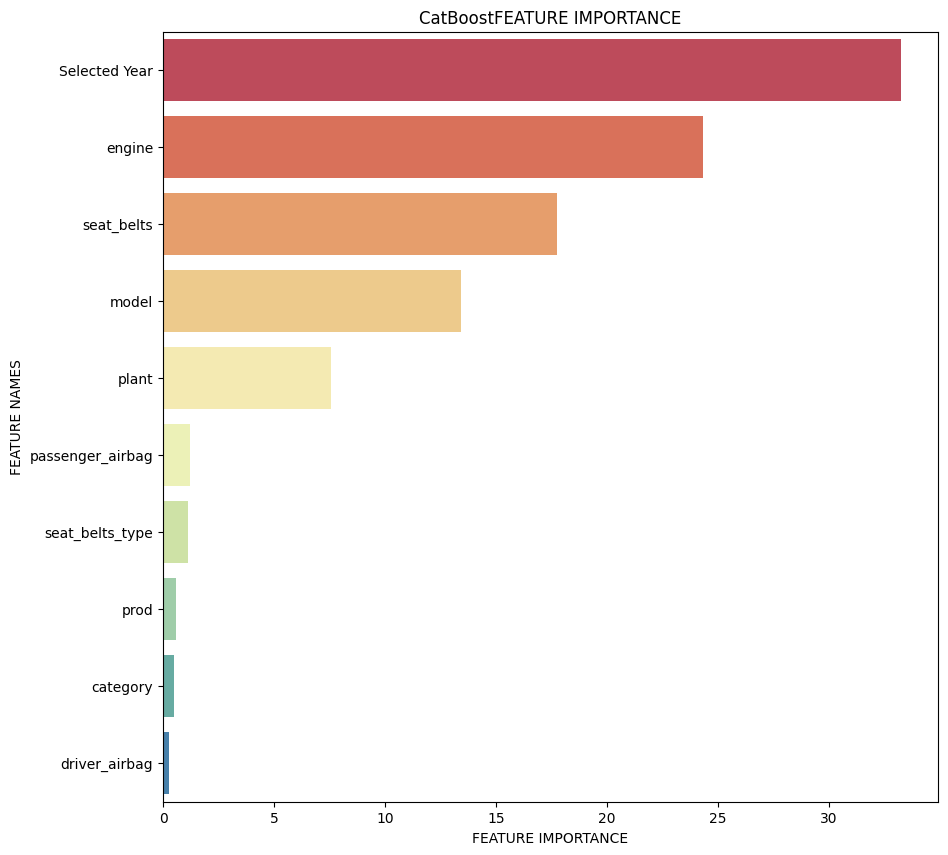

In [174]:
palette = sns.color_palette("rocket", as_cmap=True)

def plot_feature_importance(importance,names,model_type):
  feature_importance = np.array(importance) #Create arrays from feature importance and feature names
  feature_names = np.array(names)
  data={'feature_names':feature_names,'feature_importance':feature_importance}   #Create a DataFrame using a Dictionary
  fi_df = pd.DataFrame(data)
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True) #Sort the DataFrame in order decreasing feature importance
  #fi_df= fi_df.head(15)
  plt.figure(figsize=(10,10)) #Define size of bar plot
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="Spectral") #Plot Searborn bar chart
  plt.rc('ytick', labelsize= 6)
  plt.title(model_type + 'FEATURE IMPORTANCE') #Add chart labels
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

plot_feature_importance(model_bas_cb.feature_importances_, X.columns, 'CatBoost')

Выводы.

Сделано:
* регулярное выражение для парсинга вин-кодов и цены
* получилось вытащить год и название модели
* сделана Дамми- модель - RMSE 8096
* сделана кросс-валидация на CatBoost - RMSE 2669

Хотелось сделать, но не получилось:
* прикрутить тип двигателя, топливо и мощность. Не поняла как это можно сделать, с учетом что одному коду соответствует несколько моделей в зависимости от года.

Вообще проект очень понравился. Спасибо, что дали возможность немного изучить модуль re.
